# European Football Statistics

In [526]:
import pandas as pd
import numpy as np
import requests
import http.client
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

key = '80c2f8ba62244830a2eda578176435d9'

In [14]:
#Import Excel file with Club Market Values

excel = 'C:/Users/USER/Documents/Springboard/Capstone 1/club_values.xlsx'
sheets = [426, 430, 434, 436, 438]

columns = ["Clubs", "Unnamed: 1", "Squad", "Age", "Foreign players", "Total market value", "Market value"]
club_values = pd.DataFrame(columns=columns)
for i in sheets:
    df = pd.read_excel(open(excel,'rb'), sheetname= str(i))
    df = df.iloc[1:,:]
    df.columns = ["Clubs", "Unnamed: 1", "Squad", "Age", "Foreign players", "Total market value", "Market value"]
    club_values =club_values.append(df, ignore_index=True)

#Standardize Club names   

club_values.loc[24,"Clubs"]="Red Bull Leipzig"
club_values.loc[20,"Clubs"]="FC Bayern München"
club_values.loc[25,"Clubs"]="Bor. Mönchengladbach"
club_values.loc[22,"Clubs"]="Bayer Leverkusen"
club_values.loc[30,"Clubs"]="Werder Bremen"
club_values.loc[32,"Clubs"]="1. FSV Mainz "
club_values.loc[42,"Clubs"]="Olympique de Marseille"
club_values.loc[46,"Clubs"]="OSC Lille"
club_values.loc[49,"Clubs"]="Montpellier Hérault SC"
club_values.loc[44,"Clubs"]="FC Girondins de Bordeaux"
club_values.loc[56,"Clubs"]="Dijon FCO"
club_values.loc[45,"Clubs"]="Toulouse FC"
club_values.loc[57,"Clubs"]="AS Nancy"
club_values.loc[51,"Clubs"]="Angers SCO"
club_values.loc[64,"Clubs"]="Athletic Club"
club_values.loc[75,"Clubs"]="CD Leganes"
club_values.loc[60,"Clubs"]="Club Atlético de Madrid"
club_values.loc[70,"Clubs"]="Real Betis"
club_values.loc[71,"Clubs"]="RCD Espanyol"
club_values.loc[73,"Clubs"]="RC Deportivo La Coruna"
club_values.loc[97,"Clubs"]="US Cittá di Palermo"
club_values.loc[78,"Clubs"]="Juventus Turin"
club_values.loc[91,"Clubs"]="Bologna FC"
club_values.loc[94,"Clubs"]="Pescara Calcio"
club_values.loc[93,"Clubs"]="Empoli FC"
club_values.loc[81,"Clubs"]="FC Internazionale Milano"

In [19]:
#Load League Data From: http://api.football-data.org

connection = http.client.HTTPConnection('api.football-data.org')
headers = { 'X-Auth-Token': key, 'X-Response-Control': 'minified' }
connection.request('GET', '/v1/competitions/?season=2016', None, headers )
response = json.loads(connection.getresponse().read().decode())

#Create data frame of top 5 most important leagues

top_leagues_df = pd.DataFrame(response)
top_leagues_df = top_leagues_df[top_leagues_df['league'].isin(['BL1', 'FL1', 'PL', 'PD', 'SA'])]
top_leagues_df.rename(columns={'caption':'name'}, inplace=True)
top_leagues_df = top_leagues_df.reset_index()
top_leagues_df = top_leagues_df[['id', 'name', 'league', 'numberOfTeams']]
top_leagues_df['name'] = top_leagues_df['name'].map(lambda x: str(x)[:-8])
top_leagues_df.columns = ['league_id', 'league_name', 'league', 'number_of_eams']

countries = ['United Kingdom', 'Germany', 'France', 'Spain', 'Italy']
top_leagues_df['country'] = countries

In [21]:
#Load Team Data From: http://api.football-data.org

league_list = top_leagues_df['league_id']
columns = ['crestUrl', 'id', 'name', 'shortName', 'squadMarketValue', 'league_id']
teams_df = pd.DataFrame(columns=columns)
teams_df
id = 0
for i in league_list:
    connection = http.client.HTTPConnection('api.football-data.org')
    headers = { 'X-Auth-Token': key, 'X-Response-Control': 'minified' }
    connection.request('GET', '/v1/competitions/'+str(i)+'/teams', None, headers )
    response = json.loads(connection.getresponse().read().decode())
    data_df = pd.DataFrame(response)
    data_df = data_df['teams']
    teams_list=[]
    for i in data_df:
        teams_list.append(i)
    data_df = pd.DataFrame.from_dict(teams_list)
    data_df['league_id'] = league_list[id]
    teams_df = teams_df.append(data_df, ignore_index=True)
    id+=1
teams_df = teams_df.sort_values('id')

In [33]:
#loads teams' standing at end of 2016/2017 season from: http://api.football-data.org

columns = ["Home Draws", "Home Goals", "Home Goals Against", "Home Losses", "Home Wins"]
standings_df = pd.DataFrame(columns=columns)
league_list = list(top_leagues_df['league_id'])
id = 0
for i in league_list:
    url='http://api.football-data.org/v1/competitions/'+str(i)+'/leagueTable/?apikey=80c2f8ba62244830a2eda578176435d9'
    r = requests.get(url)
    json_data = r.json()
    json_data = json_data['standing']
    for i in json_data:
        data={}
        for k, v in i.items():
            if k not in ['home', 'away']:
                data[k] = v
        data_df =pd.DataFrame.from_dict(data)
        data_df = data_df.reset_index(drop=True)
        venue={}
        for k, v in i.items():
            if k in ['home', 'away']:
                venue[k] = v
        df =pd.DataFrame.from_dict(venue)
        df =df.transpose()
        away_df =pd.DataFrame(df.iloc[0,:])
        away_df =away_df.transpose()
        away_df.columns = ["Away Draws", "Away Goals", "Away Goals Against", "Away Losses", "Away Wins"]
        away_df = away_df.reset_index(drop=True)
        home_df =pd.DataFrame(df.iloc[1,:])
        home_df =home_df.transpose()
        home_df.columns = ["Home Draws", "Home Goals", "Home Goals Against", "Home Losses", "Home Wins"]
        home_df = home_df.reset_index(drop=True)
        venue_df = pd.concat([home_df, away_df], axis=1)
        team_stats_df = pd.concat([data_df, venue_df], axis=1)
        team_stats_df = team_stats_df.set_index('_links')
        team_stats_df['league_id'] = league_list[id]
        standings_df = standings_df.append(team_stats_df, ignore_index=True)
    id += 1

In [25]:
# Load Player Data From: http://api.football-data.org

#Creates Data Frame for half of players

columns = ['id', 'name', 'dateOfBirth', 'position', 'nationality', 'marketValue', 'jerseyNumber', 'contractUntil']
players_df1 = pd.DataFrame(columns=columns)
teams_list = list(teams_df['id'])
teams_list = teams_list[0:49]
id = 0
for i in teams_list:
    connection = http.client.HTTPConnection('api.football-data.org')
    headers = { 'X-Auth-Token': key, 'X-Response-Control': 'minified' }
    connection.request('GET', '/v1/teams/'+str(i)+'/players', None, headers )
    response = json.loads(connection.getresponse().read().decode())     
    data_df = pd.DataFrame(response)
    data_df = data_df['players']
    players_list=[]
    for i in data_df:
        players_list.append(i)
    data_df = pd.DataFrame.from_dict(players_list)
    data_df['team_id'] = teams_list[id]
    players_df1 = players_df1.append(data_df, ignore_index=True)
    id+=1

In [27]:
#Creates Data Frame for second half of players    
    
columns = ['id', 'name', 'dateOfBirth', 'position', 'nationality', 'marketValue', 'jerseyNumber', 'contractUntil']
players_df2 = pd.DataFrame(columns=columns)
teams_list = list(teams_df['id'])
teams_list = teams_list[49:]
id = 0
for i in teams_list:
    connection = http.client.HTTPConnection('api.football-data.org')
    headers = { 'X-Auth-Token': key, 'X-Response-Control': 'minified' }
    connection.request('GET', '/v1/teams/'+str(i)+'/players', None, headers )
    response = json.loads(connection.getresponse().read().decode())     
    data_df = pd.DataFrame(response)
    data_df = data_df['players']
    players_list=[]
    for i in data_df:
        players_list.append(i)
    data_df = pd.DataFrame.from_dict(players_list)
    data_df['team_id'] = teams_list[id]
    players_df2 = players_df2.append(data_df, ignore_index=True)
    id+=1

In [28]:
#Merge players data frames into one
players_df = players_df1.append(players_df2, ignore_index=True)

In [31]:
#Renames, reorders and changes columns data types for leagues data frame

Top_leagues_df = top_leagues_df[['league_id', 'league_name', 'number_of_eams', 'country']]
Top_leagues_df.loc[:,'league_id'], Top_leagues_df.loc[:,'number_of_eams'] = Top_leagues_df.loc[:,'league_id'].astype(int), Top_leagues_df.loc[:,'number_of_eams'].astype(int)
Top_leagues_df.columns = ["League ID", "League Name", "Number of Teams", "Country"]

C:\Users\USER\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [507]:
#Renames, reorders and changes columns data types for teams data frame

Teams_df = teams_df[['id', 'name', 'squadMarketValue', 'league_id']]
Teams_df.loc[:,'id'], Teams_df.loc[:,'league_id'] = Teams_df.loc[:,'id'].astype(int), Teams_df.loc[:,'league_id'].astype(int)
Teams_df.columns = ["Team ID", "Team Name", "Team Value Mill. €", "League ID"]
Teams_df = pd.merge(Teams_df, Top_leagues_df, on= "League ID")
Teams_df = Teams_df.drop("Number of Teams", 1)
Teams_df = Teams_df.sort_values("Team Name")
Teams_df = Teams_df.sort_values("League Name")
Teams_df =Teams_df.reset_index(drop=True)

#Adds market value from club values data frame

for x in club_values.itertuples():
     for i in Teams_df.itertuples():
        if x[1] in i[2]:
            Teams_df.set_value(i[0], "Team Value Mill. €", x[6])

Teams_df['Team Value Mill. €'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
Teams_df[['Team Value Mill. €']] = Teams_df[['Team Value Mill. €']].astype(int)
Teams_df["Team Value Mill. €"] = Teams_df["Team Value Mill. €"]/100

C:\Users\USER\Anaconda3\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\USER\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [508]:
#Renames, reorders standings data frame

Standings_df = standings_df[['position','teamName', 'wins', 'draws', 'losses', 'goals',
                             'goalsAgainst', 'goalDifference', 'points', 'Home Wins', 'Home Losses',
                             'Home Draws', 'Home Goals', 'Home Goals Against', 'Away Wins',
                             'Away Draws', 'Away Losses','Away Goals', 'Away Goals Against',
                             'crestURI']]
Standings_df.columns=  ["Position","Team Name", "Wins", "Draws", "Losses", "Goals",
                        "Goals Against", "Goal Difference", "Points", "Home Wins", "Home Losses",
                        "Home Draws", "Home Goals", "Home Goals Against", "Away Wins",
                        "Away Draws", "Away Losses","Away Goals", "Away Goals Against",
                         "Crest"]

In [509]:
#Renames, reorders players data frame
Players_df = players_df[['id', 'name', 'position', 'marketValue', 'dateOfBirth',
                         'contractUntil', 'nationality', 'team_id', 'jerseyNumber']]
Players_df.loc[:,'id'], Players_df.loc[:,'team_id'] = Players_df.loc[:,'id'].astype(int), Players_df.loc[:,'team_id'].astype(int)
Players_df.columns = ["Player Id", "Name", "Position", "Market Value", "Date of Birth",
                      "Contract Until", "Nationality", "Team ID", "Jersey Number"]
Players_df = pd.merge(Players_df, Teams_df, on= "Team ID")
Players_df = Players_df.drop(["Country", "League ID", "Team Value Mill. €"], 1)
Players_df = Players_df.sort_values("Name")
Players_df = Players_df.sort_values("League Name")

In [510]:
#Creates Team Stat Summary

Summary_df = pd.merge(Standings_df, Teams_df, on= "Team Name")
Summary_df = Summary_df.drop(['Home Wins',
       'Home Losses', 'Home Draws', 'Home Goals', 'Home Goals Against',
       'Away Wins', 'Away Draws', 'Away Losses', 'Away Goals',
       'Away Goals Against', 'Crest', 'Team ID','League ID', 'Country'], 1)

# Output Tables

Top Leagues Table&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Shape : 5 x 4



In [511]:
Top_leagues_df.head(5)

,League ID,League Name,Number of Teams,Country
0,426,Premier League,20,United Kingdom
1,430,1. Bundesliga,18,Germany
2,434,Ligue 1,20,France
3,436,Primera Division,20,Spain
4,438,Serie A,20,Italy


.

Teams Table&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Shape : 98 x 6


In [512]:
Teams_df.head(5)

,Team ID,Team Name,Team Value Mill. €,League ID,League Name,Country
0,1,1. FC Köln,112.85,430,1. Bundesliga,Germany
1,721,Red Bull Leipzig,163.38,430,1. Bundesliga,Germany
2,17,SC Freiburg,81.85,430,1. Bundesliga,Germany
3,16,FC Augsburg,58.73,430,1. Bundesliga,Germany
4,55,SV Darmstadt 98,20.40,430,1. Bundesliga,Germany


.

Standings Leagues Table&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Shape : 98 x 22

Columns ='Away Draws', 'Away Goals', 'Away Goals Against', 'Away Losses',
       'Away Wins', 'Home Draws', 'Home Goals', 'Home Goals Against',
       'Home Losses', 'Home Wins', 'crestURI', 'draws', 'goalDifference',
       'goals', 'goalsAgainst', 'league_id', 'losses', 'playedGames', 'points',
       'position', 'teamName', 'wins'


In [513]:
Standings_df.head(5)

,Position,Team Name,Wins,Draws,Losses,Goals,Goals Against,Goal Difference,Points,Home Wins,Home Losses,Home Draws,Home Goals,Home Goals Against,Away Wins,Away Draws,Away Losses,Away Goals,Away Goals Against,Crest
0,1.0,Chelsea FC,27.0,3.0,5.0,76.0,32.0,44.0,84.0,15,2,0,47,16,12.0,3.0,3.0,29.0,16.0,http://upload.wikimedia.org/wikipedia/de/5/5c/...
1,2.0,Tottenham Hotspur FC,24.0,8.0,3.0,77.0,23.0,54.0,80.0,16,0,2,45,8,8.0,6.0,3.0,32.0,15.0,http://upload.wikimedia.org/wikipedia/de/b/b4/...
2,3.0,Manchester City FC,20.0,9.0,6.0,68.0,38.0,30.0,69.0,9,1,7,30,16,11.0,2.0,5.0,38.0,22.0,https://upload.wikimedia.org/wikipedia/en/e/eb...
3,4.0,Liverpool FC,20.0,9.0,6.0,71.0,42.0,29.0,69.0,11,2,4,42,18,9.0,5.0,4.0,29.0,24.0,http://upload.wikimedia.org/wikipedia/de/0/0a/...
4,5.0,Arsenal FC,20.0,6.0,9.0,68.0,42.0,26.0,66.0,12,2,3,34,15,8.0,3.0,7.0,34.0,27.0,http://upload.wikimedia.org/wikipedia/en/5/53/...


.

Players Table&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Shape : 2465 x 11


In [514]:
Players_df.head(5)

,Player Id,Name,Position,Market Value,Date of Birth,Contract Until,Nationality,Team ID,Jersey Number,Team Name,League Name
419,839,Örjan Nyland,Keeper,None,1990-09-10,2019-06-30,Norway,31,1,FC Ingolstadt 04,1. Bundesliga
418,838,Martin Hansen,Keeper,None,1990-06-15,2020-06-30,Denmark,31,35,FC Ingolstadt 04,1. Bundesliga
229,679,Daniel Didavi,Attacking Midfield,None,1990-02-21,2021-06-30,Germany,11,11,VfL Wolfsburg,1. Bundesliga
426,846,Markus Suttner,Left-Back,None,1987-04-16,2018-06-30,Austria,31,29,FC Ingolstadt 04,1. Bundesliga
445,885,Daniel Heuer Fernandes,Keeper,None,1992-11-13,2018-06-30,Portugal,55,1,SV Darmstadt 98,1. Bundesliga


.

Summary Table&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Shape : 98 x 11

In [515]:
Summary_df.head(5)

,Position,Team Name,Wins,Draws,Losses,Goals,Goals Against,Goal Difference,Points,Team Value Mill. €,League Name
0,1.0,Chelsea FC,27.0,3.0,5.0,76.0,32.0,44.0,84.0,557.75,Premier League
1,2.0,Tottenham Hotspur FC,24.0,8.0,3.0,77.0,23.0,54.0,80.0,494.50,Premier League
2,3.0,Manchester City FC,20.0,9.0,6.0,68.0,38.0,30.0,69.0,543.25,Premier League
3,4.0,Liverpool FC,20.0,9.0,6.0,71.0,42.0,29.0,69.0,422.20,Premier League
4,5.0,Arsenal FC,20.0,6.0,9.0,68.0,42.0,26.0,66.0,517.00,Premier League


# Data Story

In [732]:
# Champions League Allocated Spots by League

columns = ['Rank', 'League', 'Teams']
Champions_df = pd.DataFrame(columns=columns)
Champions_df['Rank'] = range(1,6)
Champions_df['League'] = ['Primera Divison', '1. Bundesliga', 'Premier League', 'Serie A', 'Ligue 1']
Champions_df['Teams'] = [4,4,4,3,3]
Champions_df

,Rank,League,Teams
0,1,Primera Divison,4
1,2,1. Bundesliga,4
2,3,Premier League,4
3,4,Serie A,3
4,5,Ligue 1,3


According to Uefa: "The associations' club coefficients rankings are based on the results of each association's clubs in the five previous UEFA Champions League and UEFA Europa League seasons. The rankings determine the number of places allocated to an association (country) in forthcoming UEFA club competition." The table above displayes the number of spots allocated from each of Europe's top leagues. The last ranked team from the table above from each league will enter a play-off round to qualify. The Europa League winner also automatically qualifies to the Champions League, regardless of their season performance.

source: http://www.uefa.com/memberassociations/uefarankings/country/

In [717]:
#Creates Data Frame of Teams Automatically Qualified for Champions League Group Stage

PL = Summary_df[Summary_df["League Name"]=='Premier League'][Summary_df["Position"].isin([1,2,3])]
PD = Summary_df[Summary_df["League Name"]=='Primera Division'][Summary_df["Position"].isin([1,2,3])]
BL = Summary_df[Summary_df["League Name"]=='1. Bundesliga'][Summary_df["Position"].isin([1,2,3])]
SA = Summary_df[Summary_df["League Name"]=='Serie A'][Summary_df["Position"].isin([1,2])]
FL = Summary_df[Summary_df["League Name"]=='Ligue 1'][Summary_df["Position"].isin([1,2])]
CL_teams = PL.append(PD, ignore_index=True)
CL_teams = CL_teams.append(BL, ignore_index=True)
CL_teams = CL_teams.append(SA, ignore_index=True)
CL_teams = CL_teams.append(FL, ignore_index=True)

#Creates Data Frame of Teams on Champions League Play-off Round

PLR = Summary_df[Summary_df["League Name"]=='Premier League'][Summary_df["Position"].isin([4])]
PDR = Summary_df[Summary_df["League Name"]=='Primera Division'][Summary_df["Position"].isin([4])]
BLR = Summary_df[Summary_df["League Name"]=='1. Bundesliga'][Summary_df["Position"].isin([4])]
SAR = Summary_df[Summary_df["League Name"]=='Serie A'][Summary_df["Position"].isin([3])]
FLR = Summary_df[Summary_df["League Name"]=='Ligue 1'][Summary_df["Position"].isin([3])]
CR_teams = PLR.append(PDR, ignore_index=True)
CR_teams = CR_teams.append(BLR, ignore_index=True)
CR_teams = CR_teams.append(SAR, ignore_index=True)
CR_teams = CR_teams.append(FLR, ignore_index=True)
CR_teams

#Creates Data Frame of Europa League Winner (Qualifies Automatically to Champions League)

EL_team = Summary_df[Summary_df["Team Name"]=='Manchester United FC']

#Creates Data Frame of Teams Not Qualified to Champions League

No_CL = Summary_df[Summary_df["Position"]>3]
No_CL = No_CL[No_CL["Team Name"]!='Liverpool FC']
No_CL = No_CL[No_CL["Team Name"]!='TSG 1899 Hoffenheim']
No_CL = No_CL[No_CL["Team Name"]!='Sevilla FC']
No_CL = No_CL[No_CL["Team Name"]!='Manchester United FC']

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning:

Boolean Series key will be reindexed to match D

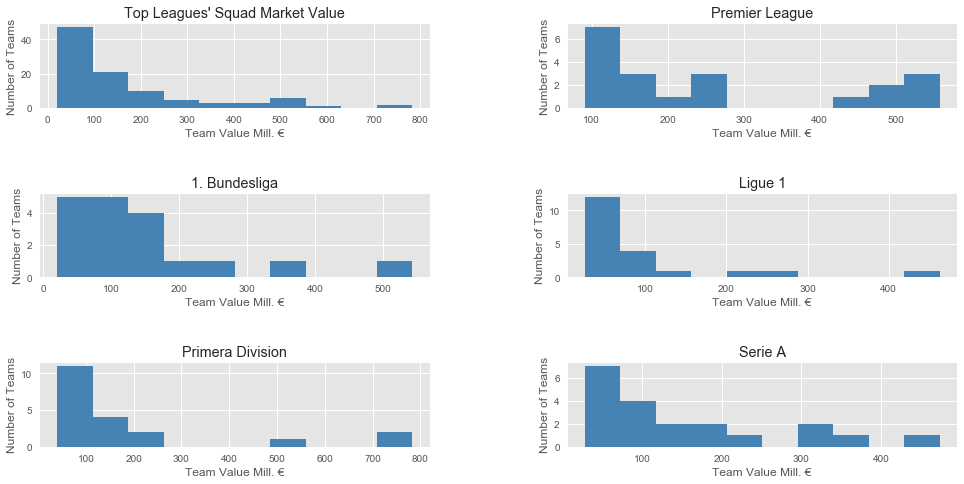

In [516]:
from matplotlib.ticker import NullFormatter 

plt.subplot(321)
plt.hist(Summary_df["Team Value Mill. €"], color='steelblue')
plt.title("Top Leagues' Squad Market Value")
plt.ylabel("Number of Teams")
plt.xlabel("Team Value Mill. €")
plt.grid(True)


# Premier League
plt.subplot(322)
plt.hist(Summary_df[Summary_df['League Name']=="Premier League"]["Team Value Mill. €"], color='steelblue')
plt.title('Premier League')
plt.ylabel("Number of Teams")
plt.xlabel("Team Value Mill. €")
plt.grid(True)

# Bundesliga
plt.subplot(323)
plt.hist(Summary_df[Summary_df['League Name']=="1. Bundesliga"]["Team Value Mill. €"], color='steelblue')
plt.title('1. Bundesliga')
plt.ylabel("Number of Teams")
plt.xlabel("Team Value Mill. €")
plt.grid(True)


# Ligue 1
plt.subplot(324)
plt.hist(Summary_df[Summary_df['League Name']=="Ligue 1"]["Team Value Mill. €"], color='steelblue')
plt.title('Ligue 1')
plt.ylabel("Number of Teams")
plt.xlabel("Team Value Mill. €")
plt.grid(True)

# Primera Division
plt.subplot(325)
plt.hist(Summary_df[Summary_df['League Name']=="Primera Division"]["Team Value Mill. €"], color='steelblue')
plt.title('Primera Division')
plt.ylabel("Number of Teams")
plt.xlabel("Team Value Mill. €")
plt.grid(True)

# Serie A
plt.subplot(326)
plt.hist(Summary_df[Summary_df['League Name']=="Serie A"]["Team Value Mill. €"], color='steelblue')
plt.title('Serie A')
plt.ylabel("Number of Teams")
plt.xlabel("Team Value Mill. €")
plt.grid(True)


plt.gca().yaxis.set_minor_formatter(NullFormatter())

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1,
                    wspace=0.35)
plt.show()
plt.figure(figsize=(15,7))
None

The distribution of the team market values are skewed to the right. The Premier League appears to have a more even distribution whereas the other leagues have a few teams worth more than the rest.

In [735]:
import plotly.plotly as py
import plotly.graph_objs
plotly.tools.set_credentials_file(username='gpguerra', api_key='56kn61TUzvnHLDuAdpwN')

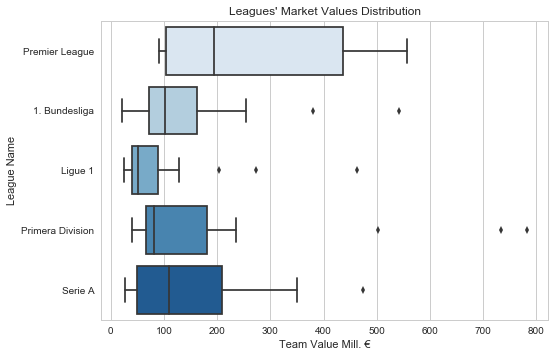

In [807]:
#Creats Boxpots for Each league with Outliers
ax = plt.axes()
x = Summary_df["Team Value Mill. €"]
y = Summary_df['League Name']
sns.boxplot(x=x, y=y, palette='Blues')
ax.set_title("Leagues' Market Values Distribution")
plt.show()

The figure above allows for better comparisons of the different distributions of team values. All of the leagues except for the Premier League has outliers. Primera Division has two extreme outliers (Real Madrid & Barcelona) which are worth more than any other team in all of the leagues. 

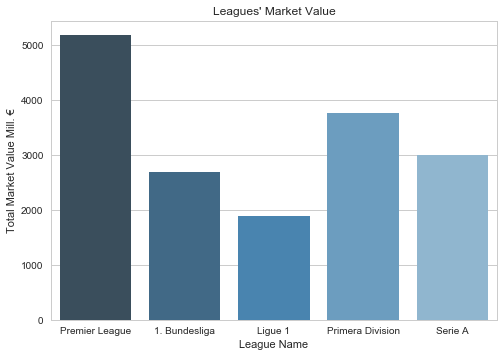

In [738]:
#Bar Plot of Leagues' Market Value

ax = plt.axes()
sns.set(style="whitegrid")

x0 = int(Summary_df[Summary_df['League Name']=="Premier League"]["Team Value Mill. €"].sum())
x1 = int(Summary_df[Summary_df['League Name']=="1. Bundesliga"]["Team Value Mill. €"].sum())
x2 = int(Summary_df[Summary_df['League Name']=="Ligue 1"]["Team Value Mill. €"].sum())
x3 = int(Summary_df[Summary_df['League Name']=="Primera Division"]["Team Value Mill. €"].sum())
x4 = int(Summary_df[Summary_df['League Name']=="Serie A"]["Team Value Mill. €"].sum())

values = [x0, x1, x2, x3, x4]

columns = ["Market Value Mill. €"]
df = pd.DataFrame(columns=columns)
df['Market Value Mill. €'] = values

x = Top_leagues_df['League Name']
y = df['Market Value Mill. €']

sns.barplot(x=x, y=y, data=crashes, color="b", palette='Blues_d', ax=ax)
ax.set_title("Leagues' Market Value")
ax.set_ylabel("Total Market Value Mill. €")
plt.show()

The Premier League's players are worth far more than the rest of the other leagues with Primera Division coming in second. It is  important to note that this table reflects a sum value of all players in each league. Since 1. Bundesliga has 18 teams (two less than the other leagues), a bar plot reflecting average values may be more appropriate. Also, Primera Division has two extreme outliers that push the market value of the whole league.

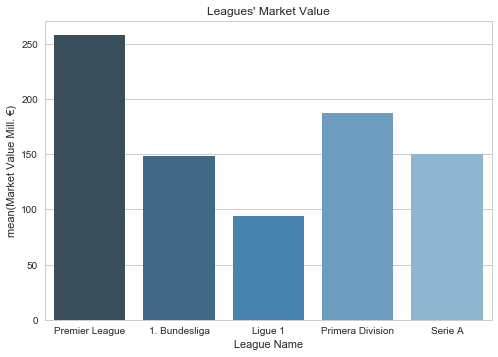

In [739]:
#Bar Plot of Leagues' Mean Market Value

ax = plt.axes()
sns.set(style="whitegrid")

x0 = int(Summary_df[Summary_df['League Name']=="Premier League"]["Team Value Mill. €"].mean())
x1 = int(Summary_df[Summary_df['League Name']=="1. Bundesliga"]["Team Value Mill. €"].mean())
x2 = int(Summary_df[Summary_df['League Name']=="Ligue 1"]["Team Value Mill. €"].mean())
x3 = int(Summary_df[Summary_df['League Name']=="Primera Division"]["Team Value Mill. €"].mean())
x4 = int(Summary_df[Summary_df['League Name']=="Serie A"]["Team Value Mill. €"].mean())

values = [x0, x1, x2, x3, x4]

columns = ["Market Value Mill. €"]
df = pd.DataFrame(columns=columns)
df['Market Value Mill. €'] = values

x = Top_leagues_df['League Name']
y = df['Market Value Mill. €']

sns.barplot(x=x, y=y, data=crashes, color="b", palette='Blues_d', ax=ax)
ax.set_title("Leagues' Market Value")
plt.show()

Using mean values, there is an apparent increase in 1.Bundesliga's value. The Premier League, still remains the most expensive league in terms of team value, with Primera Division, Serie A, 1. Bundesliga, and Ligue 1 following in order.

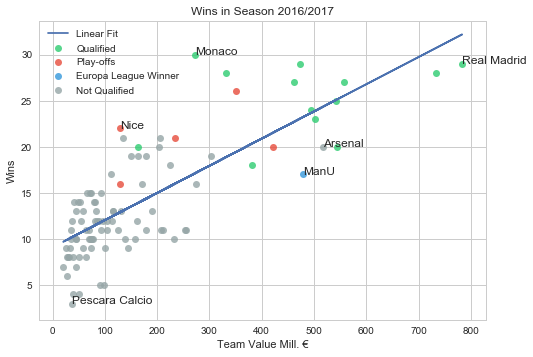

correlation coefficient: 0.78


In [880]:
#Creates Scatter Plot of Wins in the Last Season and Team Market Value
ax = plt.axes()
x = Summary_df["Team Value Mill. €"]
y = Summary_df["Wins"]

x1 = CL_teams["Team Value Mill. €"]
x2 = CR_teams["Team Value Mill. €"]
x3 = EL_team["Team Value Mill. €"]
x4 = No_CL["Team Value Mill. €"]

y1 = CL_teams["Wins"]
y2 = CR_teams["Wins"]
y3 = EL_team["Wins"]
y4 = No_CL["Wins"]

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.plot(x, line)
sns.regplot(x=x1, y=y1, fit_reg=False, color="#2ecc71")
sns.regplot(x=x2, y=y2, fit_reg=False, color="#e74c3c")
sns.regplot(x=x3, y=y3, fit_reg=False, color="#3498db")
sns.regplot(x=x4, y=y4, fit_reg=False, color="#95a5a6")


plt.text(Summary_df[Summary_df["Team Name"]=="Real Madrid CF"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="Real Madrid CF"]["Wins"], 'Real Madrid')
plt.text(Summary_df[Summary_df["Team Name"]=="Arsenal FC"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="Arsenal FC"]["Wins"], 'Arsenal')
plt.text(Summary_df[Summary_df["Team Name"]=="Manchester United FC"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="Manchester United FC"]["Wins"], 'ManU')
plt.text(Summary_df[Summary_df["Team Name"]=="AS Monaco FC"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="AS Monaco FC"]["Wins"], 'Monaco')
plt.text(Summary_df[Summary_df["Team Name"]=="OGC Nice"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="OGC Nice"]["Wins"], 'Nice')
plt.text(Summary_df[Summary_df["Team Name"]=="Pescara Calcio"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="Pescara Calcio"]["Wins"], 'Pescara Calcio')


ax.set_title("Wins in Season 2016/2017")
ax.legend(labels=('Linear Fit', 'Qualified', 'Play-offs', 'Europa League Winner', 'Not Qualified'))
plt.show()
#Print Correlation Coefficient
print('correlation coefficient: ' + str(round(np.corrcoef(Summary_df["Team Value Mill. €"], Summary_df["Wins"])[0][1],2)))

There is a strong positive relationship between how many games a club wins in a season and the value of its players. A correlation coefficient of 0.78 reflects this relationship. From the scatter plot above, all of the team worth over 330 million, except for Arsenal FC have qualified or made the play-off round for the Champions League. Manchester United made it through by winning the Europa League, but from the graph above, it is apparent for a club of its stature, the club had a mediocre if not poor season. The squad is worth over 450 million, but only managed to win 17 games rather than 23 suggested by the linear fit. AS Monaco seems to be the most effective team, having won 30 games with a team value of 272 million. OGC Nice looks like the team revelation of the season winning 23 games with a team worth less than 130 million.

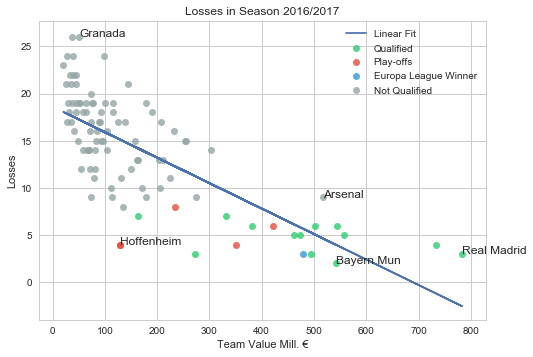

correlation coefficient: -0.74


In [893]:
#Creates Scatter Plot of Losses in the Last Season and Team Market Value
ax = plt.axes()
x = Summary_df["Team Value Mill. €"]
y = Summary_df["Losses"]

x1 = CL_teams["Team Value Mill. €"]
x2 = CR_teams["Team Value Mill. €"]
x3 = EL_team["Team Value Mill. €"]
x4 = No_CL["Team Value Mill. €"]

y1 = CL_teams["Losses"]
y2 = CR_teams["Losses"]
y3 = EL_team["Losses"]
y4 = No_CL["Losses"]

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.plot(x, line)
sns.regplot(x=x1, y=y1, fit_reg=False, color="#2ecc71")
sns.regplot(x=x2, y=y2, fit_reg=False, color="#e74c3c")
sns.regplot(x=x3, y=y3, fit_reg=False, color="#3498db")
sns.regplot(x=x4, y=y4, fit_reg=False, color="#95a5a6")


plt.text(Summary_df[Summary_df["Team Name"]=="Real Madrid CF"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="Real Madrid CF"]["Losses"], 'Real Madrid')
plt.text(Summary_df[Summary_df["Team Name"]=="Arsenal FC"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="Arsenal FC"]["Losses"], 'Arsenal')
plt.text(Summary_df[Summary_df["Team Name"]=="TSG 1899 Hoffenheim"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="TSG 1899 Hoffenheim"]["Losses"], 'Hoffenheim')
plt.text(Summary_df[Summary_df["Team Name"]=="FC Bayern München"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="FC Bayern München"]["Losses"], 'Bayern Mun')
plt.text(Summary_df[Summary_df["Team Name"]=="Granada CF"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="Granada CF"]["Losses"], 'Granada')


ax.set_title("Losses in Season 2016/2017")
ax.legend(labels=('Linear Fit', 'Qualified', 'Play-offs', 'Europa League Winner', 'Not Qualified'))
plt.show()
#Print Correlation Coefficient
print('correlation coefficient: ' + str(round(np.corrcoef(Summary_df["Team Value Mill. €"], Summary_df["Losses"])[0][1],2)))

There is a negative relationship between losses and a team's market value. Again, Arsenal FC stands out for losing the most games (9) for teams worth over 350 million. OGC Nice and TSG 1899 Hoffenheim only lost 4 games with teams worth less than 140 million.

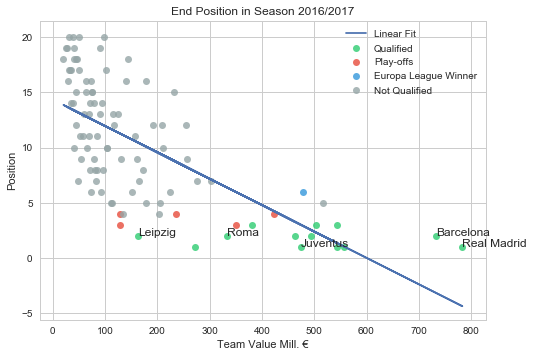

correlation coefficient: -0.69


In [892]:
#Creates Scatter Plot of Position in the Last Season and Team Market Value
ax = plt.axes()
x = Summary_df["Team Value Mill. €"]
y = Summary_df["Position"]

x1 = CL_teams["Team Value Mill. €"]
x2 = CR_teams["Team Value Mill. €"]
x3 = EL_team["Team Value Mill. €"]
x4 = No_CL["Team Value Mill. €"]

y1 = CL_teams["Position"]
y2 = CR_teams["Position"]
y3 = EL_team["Position"]
y4 = No_CL["Position"]

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.plot(x, line)
sns.regplot(x=x1, y=y1, fit_reg=False, color="#2ecc71")
sns.regplot(x=x2, y=y2, fit_reg=False, color="#e74c3c")
sns.regplot(x=x3, y=y3, fit_reg=False, color="#3498db")
sns.regplot(x=x4, y=y4, fit_reg=False, color="#95a5a6")


plt.text(Summary_df[Summary_df["Team Name"]=="Real Madrid CF"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="Real Madrid CF"]["Position"], 'Real Madrid')
plt.text(Summary_df[Summary_df["Team Name"]=="Red Bull Leipzig"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="Red Bull Leipzig"]["Position"], 'Leipzig')
plt.text(Summary_df[Summary_df["Team Name"]=="FC Barcelona"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="FC Barcelona"]["Position"], 'Barcelona')
plt.text(Summary_df[Summary_df["Team Name"]=="Juventus Turin"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="Juventus Turin"]["Position"], 'Juventus')
plt.text(Summary_df[Summary_df["Team Name"]=="AS Roma"]["Team Value Mill. €"], Summary_df[Summary_df["Team Name"]=="AS Roma"]["Position"], 'Roma')


ax.set_title("End Position in Season 2016/2017")
ax.legend(labels=('Linear Fit', 'Qualified', 'Play-offs', 'Europa League Winner', 'Not Qualified'))
plt.show()
#Print Correlation Coefficient
print('correlation coefficient: ' + str(round(np.corrcoef(Summary_df["Team Value Mill. €"], Summary_df["Position"])[0][1],2)))

From the graph above, Red Bull Leipzig stands out by reaching the second position in their league with a team worth a merely 163 million. Real Madrid and Barcelona are at the end of the scale in term of team value, but they most compete against each other. Juventus Turin made to the top spot in Serie A with a team worth more than 100 million than their closest rival (AS Roma). Juventus must still compete in the Champions League against teams like Real Madrid and Barcelona, so it makes sense for them to have a team worth considerably compared to the rest of Seria A clubs.